In [1]:
##INSTALL THESE REQUIREMENTS IF YOU DONT ALREADY HAVE IT 

# !pip install tensorflow
# !pip install opencv-contrib-python
# !pip install opencv-python numpy

In [1]:
# import all libraries required

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import re
import collections
import os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import time
import pickle 
import cv2
from skimage import measure
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

2024-05-22 08:01:22.854664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#download flikr8k dataset - this part needs to be revi
BASE_DIR = '/Users/hajimeluka/Desktop/UNI/Y4/Advanced Topics/Code/'

if not os.path.exists(f'{BASE_DIR}/data/'):
    api_token = {"username":"hajimeluka","key":"0390d06cdb82c33d57f59406c95b1aec"}
    
    with open(f'{BASE_DIR}/kaggle.json','w') as file: 
        json.dump(api_token, file)
    
    os.environ["KAGGLE_CONFIG_DIR"] = BASE_DIR
    os.system('kaggle datasets download -d adityajn105/flikr8k')
    os.mkdirs(f'{BASE_DIR}/data/', exist_ok=True)
    os.system(f'mv{BASE_DIR}/data/flikr8k.zip {BASE_DIR}/data/flikr8k.zip')
    os.system(f'unzip -q {BASE_DIR}/data/flikr8k.zip -d {BASE_DIR}/data')
    os.remove(f'{BASE_DIR}/data/flikr8k.zip')
    
                      

In [3]:
#display the dataset 
captions_with_base = pd.read_csv(f'{BASE_DIR}/data/captions.txt')

captions = pd.read_csv(f'{BASE_DIR}/data/captions.txt')
captions.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
print(captions.shape)

(40455, 2)


In [5]:
# concatenate base directory with x 
captions_with_base['image'] = captions['image'].apply(
    lambda x: f'{BASE_DIR}/data/Images{x}')

# Text Preprocessing

In [6]:
#apply pre-processing on captions.txt file from dataset to make it training ready
def preprocess(text):
    #make all letters lowercase 
    text = text.lower()
    
    #remove punctuations 
    text = re.sub(r'[^\w\s]','',text)
    
    #remove extra spaces
    text = re.sub('\s+',' ',text)
    text = text.strip()
    
    #add [start] and [end] special token
    text = '[start] ' + text + ' [end]'
    
    return text
    

In [7]:
#output processed dataset 
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()


,image,caption
0,1000268201_693b08cb0e.jpg,[start] a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,[start] a girl going into a wooden building [end]
2,1000268201_693b08cb0e.jpg,[start] a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,[start] a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,[start] a little girl in a pink dress going in...


# Text Vectorisation

In [8]:
#maps each word to an individual integer as NN can only deal with numbers
max_length = 40 # max number of words in sentence
vocabulary_size = 5000 #max vocab size 

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize = None,
    output_sequence_length=max_length
)

tokenizer.adapt(captions['caption'])

In [9]:
tokenizer(['a dog running'])

<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
array([[ 2, 10, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [10]:
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

In [11]:
#creating word to index and index to word for easy conversion

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [12]:
#define directory where dataset is stored 
image_dir = "/Users/hajimeluka/Desktop/UNI/Y4/Advanced Topics/Code/data/Images/."
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.io.read_file(img_path)  # read image file
        img = tf.image.decode_jpeg(img, channels=3)  # load as tensor
        img = tf.image.resize(img, (299, 299))  # resize image
        img = img / 255.0  # normalize
        images.append(img)
    return images


#ensure that there are 8k images 
images = load_images(image_dir)
print(len(images))

8091


In [13]:
#create function for extracting feature vectors using the imagenet dataset 
def extract_feature_vector(images_arr):
    # Load InceptionV3 model pretrained on ImageNet dataset
    model = tf.keras.applications.InceptionV3(
    weights = 'imagenet',
    include_top=False
    )

    images_np = [img.numpy() for img in images_arr]
    resized_imgs = [cv2.resize(img, (299, 299)) for img in images_np]
    preprocessed_imgs = preprocess_input(np.array(resized_imgs))

    #extract feature vectors using the predefined inceptionV3 model 
    feature_vectors = model.predict(preprocessed_imgs)

    return feature_vectors

In [14]:
# #THIS NEEDS TO BE RUN ONE TIME, AND THEN IT IS ABLE TO BE COMMENTED OUT AS THE FEATURE VECTORS GET SAVED IN A FILE 

# # Populate the feature_vectors column
# feature_vector = extract_feature_vector(images)
# np.save('feature_vectors.npy', feature_vector)

# print(feature_vector[0])
# # 
# # Save the updated DataFrame back to captions.txt
# # captions.to_csv('captions.txt', index=False)

In [15]:
feature_vector = np.load('feature_vectors.npy')

In [16]:
print(feature_vector[100])

[[[0.32486975 0.28514925 0.68446636 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.47627527 ... 0.         0.         0.        ]
  [0.00877726 1.5091138  0.9137454  ... 0.         0.         0.        ]]

 [[0.         0.         0.03437407 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.01801938 0.         0.        ]
  ...
  [0.         0.         0.         ... 0.07809211 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.06235992 ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.19109185 0.         0.        ]
  [0.         0.      

In [17]:
# #map image to corresponding feature vector 
# fv_image_map = map(extract_feature_vector, images)

# # Get the individual result
# first_result = next(fv_image_map)
# second_result = next(fv_image_map)

# # Print the first result
# print(first_result)

In [18]:
#ensure that captions and images are ordered the same way 
#define directory of dataset where images are stored 
image_dir = "/Users/hajimeluka/Desktop/UNI/Y4/Advanced Topics/Code/data/Images"

#sort items in the images directory 
def sort_directory(directory):
    items = os.listdir(directory)
    sorted_items = sorted(items)
    return sorted_items

sorted_images = sort_directory(image_dir)

#print sorted images
sorted_images

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

# Train-Validation Split 

SECOND APPROACH - keep in mind that because we have so many rows with the same image, randomly shuffling the data then taking a fraction of it wont work as training and validation set will end up having similar images. Think of a way we can avoid this... 

In [19]:
# import random

# # Create a list of unique feature vectors
# unique_fvs = list(set(captions['feature_vector']))

# # Shuffle the list of unique feature vectors
# random.shuffle(unique_fvs)

# # Determine the index for splitting
# split_index = int(len(unique_fvs) * 0.8)

# # Split the unique feature vectors into train and validation sets
# train_fvs = unique_fvs[:split_index]
# val_fvs = unique_fvs[split_index:]

# # Filter captions based on the selected feature vectors
# train_captions = []
# val_captions = []

# for fv in train_fvs:
#     train_captions.extend(fv_to_cap_vector[fv])

# for fv in val_fvs:
#     val_captions.extend(fv_to_cap_vector[fv])


In [20]:
#use the feature_vectors array 
# create mapping between image filenames and their feature vectors
image_to_feature_vector = dict(zip(sorted_images, feature_vector))

# store captions associated with each feature vector in default dict 
fv_to_cap_vector = collections.defaultdict(list)

for image_filename, caption in zip(captions['image'], captions['caption']):
    feature_vector = image_to_feature_vector[image_filename]
    feature_vector_tuple = tuple(feature_vector.flatten())  #convert to tupple 
    fv_to_cap_vector[feature_vector_tuple].append(caption)


    
fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)


slice_index = int(len(fv_keys)*0.8)
#get everything before 0.8 mark for training set and everything after 0.8 mark for the val set 
#for 80/20 split 
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vector = []
train_captions = []

for fvt in fv_name_train_keys:
    capt_lens = len(fv_to_cap_vector[fvt])
    train_feature_vector.extend([fvt]*capt_lens)
    train_captions.extend(fv_to_cap_vector[fvt])
    
    
val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys: 
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv]* capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])


In [21]:
print(len(train_feature_vector[0]))
print(train_captions[0])


131072
[start] a blonde girl is laughing at a guy in front of her [end]


# Putitng images and captions together

In [22]:
# hyper-parameters
BATCH_SIZE = 15
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = tokenizer.vocabulary_size()

In [23]:
#make function that takes the feature vector and caption string
#and apply the tokenizer to the caption 
caption_dtype = tf.int32  # Use int32 for tokenized sequences

# Update the load_data function to ensure consistent data types
def load_data(feature_vector, caption):
    tokenized_caption = tokenizer(caption)
    return feature_vector, tf.cast(tokenized_caption, caption_dtype)  # Cast tokenized caption to the desired dtype

    

In [25]:
# function to preprocess each element in dataset
def preprocess(feature_vector, caption):
    feature_vector = tf.cast(feature_vector, tf.float32)
    caption = tf.cast(tokenizer(caption), caption_dtype)  # Tokenize the caption
    return feature_vector, caption

#create train_dataset and apply preprocess 
train_dataset = tf.data.Dataset.from_tensor_slices((train_feature_vector, train_captions))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# batch and shuffle  train_dataset
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

#do the same for validation set 
val_dataset = tf.data.Dataset.from_tensor_slices((val_feature_vectors, val_captions))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
#testing
for img, cap in train_dataset.take(1):
    print(img.shape)
    print(cap.shape)

2024-05-22 09:00:19.872571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 712 of 1000
2024-05-22 09:00:25.409234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


(15, 131072)
(15, 40)


2024-05-22 09:00:26.105822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
#create encoder class
class CNNEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = tf.expand_dims(x, axis=1)  # add a sequence length dimension
        x = tf.reshape(x, (x.shape[0], -1))  # flatten the input tensor
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [28]:
#create class for attention mechanism 
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, 1)  # add an extra dimension
        return context_vector, attention_weights


In [29]:
#create decoder class
class RNNDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units, 
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden=None):
        x = self.embedding(x)
        if hidden is None:
            hidden = tf.zeros((x.shape[0], self.units))  # hidden state
        context_vector, attention_weights = self.attention(features, hidden=hidden)
        context_vector = tf.squeeze(context_vector, axis=1)  # remove the extra dimension from the context vector
        context_vector = tf.expand_dims(context_vector, 1)  #time axis 
        x = tf.concat([context_vector, x], axis=-1)  # put together context vector and embedded input
        output, state = self.gru(x, initial_state=hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [30]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def val_evaluate(val_dataset):
    total_loss = 0
    steps = 0

    for img_tensor, target in val_dataset:
        batch_loss = 0

        # forward passing through encoder 
        features = encoder(img_tensor)

        # get the decoder hidden state
        hidden = decoder.reset_state(batch_size=target.shape[0])

        dec_input = tf.expand_dims([word2idx('[start]')] * target.shape[0], 1)

        #teacher forcing to feed result into next input
        for t in range(1, target.shape[1]):
            #pass features through decoder 
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            #compute loss 
            batch_loss = batch_loss + loss_function(target[:, t], predictions)

            #teacher forcing 
            dec_input = tf.expand_dims(target[:, t], 1)

        batch_loss /= int(target.shape[1])  #get avg loss 
        total_loss = total_loss + batch_loss
        steps = steps + 1

    return total_loss / steps


  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 09:00:57.549756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 729 of 1000
2024-05-22 09:01:02.544878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1 Loss: 2.4114:   0%|                 | 1/2158 [01:04<38:44:53, 64.67s/it]

Epoch 1 Batch 0 Loss 96.4569


Epoch 1 Loss: 1.7495:   5%|▊                 | 101/2158 [03:01<40:03,  1.17s/it]

Epoch 1 Batch 100 Loss 60.2889


Epoch 1 Loss: 1.6696:   9%|█▋                | 201/2158 [05:01<38:33,  1.18s/it]

Epoch 1 Batch 200 Loss 79.8210


Epoch 1 Loss: 1.6310:  14%|██▌               | 301/2158 [06:55<35:29,  1.15s/it]

Epoch 1 Batch 300 Loss 61.4513


Epoch 1 Loss: 1.5866:  19%|███▎              | 401/2158 [08:51<35:19,  1.21s/it]

Epoch 1 Batch 400 Loss 62.7961


Epoch 1 Loss: 1.5610:  23%|████▏             | 501/2158 [10:44<33:08,  1.20s/it]

Epoch 1 Batch 500 Loss 60.1874


Epoch 1 Loss: 1.5421:  28%|█████             | 601/2158 [12:45<31:37,  1.22s/it]

Epoch 1 Batch 600 Loss 61.2890


Epoch 1 Loss: 1.5236:  32%|█████▊            | 701/2158 [14:46<30:52,  1.27s/it]

Epoch 1 Batch 700 Loss 47.6241


Epoch 1 Loss: 1.5058:  37%|██████▋           | 801/2158 [16:47<30:00,  1.33s/it]

Epoch 1 Batch 800 Loss 40.7192


Epoch 1 Loss: 1.4897:  42%|███████▌          | 901/2158 [18:44<23:59,  1.15s/it]

Epoch 1 Batch 900 Loss 43.3456


Epoch 1 Loss: 1.4751:  46%|███████▉         | 1001/2158 [20:36<21:10,  1.10s/it]

Epoch 1 Batch 1000 Loss 63.1217


Epoch 1 Loss: 1.4590:  51%|████████▋        | 1101/2158 [22:25<19:25,  1.10s/it]

Epoch 1 Batch 1100 Loss 57.5994


Epoch 1 Loss: 1.4461:  56%|█████████▍       | 1201/2158 [24:13<16:39,  1.04s/it]

Epoch 1 Batch 1200 Loss 46.3066


Epoch 1 Loss: 1.4323:  60%|██████████▏      | 1301/2158 [25:54<14:17,  1.00s/it]

Epoch 1 Batch 1300 Loss 54.4937


Epoch 1 Loss: 1.4230:  65%|███████████      | 1401/2158 [27:34<12:55,  1.02s/it]

Epoch 1 Batch 1400 Loss 39.7496


Epoch 1 Loss: 1.4122:  70%|███████████▊     | 1501/2158 [29:15<11:26,  1.04s/it]

Epoch 1 Batch 1500 Loss 47.3810


Epoch 1 Loss: 1.4023:  74%|████████████▌    | 1601/2158 [30:58<09:19,  1.00s/it]

Epoch 1 Batch 1600 Loss 51.5177


Epoch 1 Loss: 1.3939:  79%|█████████████▍   | 1701/2158 [32:39<07:42,  1.01s/it]

Epoch 1 Batch 1700 Loss 51.9685


Epoch 1 Loss: 1.3856:  83%|██████████████▏  | 1801/2158 [34:25<06:02,  1.02s/it]

Epoch 1 Batch 1800 Loss 54.7342


Epoch 1 Loss: 1.3784:  88%|██████████████▉  | 1901/2158 [36:29<04:01,  1.06it/s]

Epoch 1 Batch 1900 Loss 47.1729


Epoch 1 Loss: 1.3712:  93%|███████████████▊ | 2001/2158 [38:06<02:32,  1.03it/s]

Epoch 1 Batch 2000 Loss 44.8938


Epoch 1 Loss: 1.3646:  97%|████████████████▌| 2101/2158 [39:45<00:56,  1.00it/s]

Epoch 1 Batch 2100 Loss 42.2666


Epoch 1 Loss: 1.3610: 100%|█████████████████| 2158/2158 [40:44<00:00,  1.13s/it]2024-05-22 09:41:31.588096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1 Loss 1.3610
Time taken for 1 epoch 2465.01 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 09:41:42.238698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 641 of 1000
2024-05-22 09:41:48.737966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 2 Loss: 1.3031:   0%|                 | 1/2158 [00:18<11:21:27, 18.96s/it]

Epoch 2 Batch 0 Loss 52.1257


Epoch 2 Loss: 1.2321:   5%|▊                 | 101/2158 [02:10<37:24,  1.09s/it]

Epoch 2 Batch 100 Loss 38.0047


Epoch 2 Loss: 1.2088:   9%|█▋                | 201/2158 [03:59<35:45,  1.10s/it]

Epoch 2 Batch 200 Loss 47.7632


Epoch 2 Loss: 1.2096:  14%|██▌               | 301/2158 [05:48<34:45,  1.12s/it]

Epoch 2 Batch 300 Loss 47.7846


Epoch 2 Loss: 1.2015:  19%|███▎              | 401/2158 [07:37<31:20,  1.07s/it]

Epoch 2 Batch 400 Loss 50.8906


Epoch 2 Loss: 1.1988:  23%|████▏             | 501/2158 [09:26<30:26,  1.10s/it]

Epoch 2 Batch 500 Loss 39.3013


Epoch 2 Loss: 1.1981:  28%|█████             | 601/2158 [11:18<28:42,  1.11s/it]

Epoch 2 Batch 600 Loss 50.2252


Epoch 2 Loss: 1.1959:  32%|█████▊            | 701/2158 [13:18<30:17,  1.25s/it]

Epoch 2 Batch 700 Loss 36.4938


Epoch 2 Loss: 1.1968:  37%|██████▋           | 801/2158 [15:14<24:56,  1.10s/it]

Epoch 2 Batch 800 Loss 34.4770


Epoch 2 Loss: 1.1941:  42%|███████▌          | 901/2158 [17:04<22:49,  1.09s/it]

Epoch 2 Batch 900 Loss 37.8981


Epoch 2 Loss: 1.1928:  46%|███████▉         | 1001/2158 [18:52<21:27,  1.11s/it]

Epoch 2 Batch 1000 Loss 51.9138


Epoch 2 Loss: 1.1899:  51%|████████▋        | 1101/2158 [20:44<19:12,  1.09s/it]

Epoch 2 Batch 1100 Loss 38.5235


Epoch 2 Loss: 1.1855:  56%|█████████▍       | 1201/2158 [22:36<16:47,  1.05s/it]

Epoch 2 Batch 1200 Loss 60.0961


Epoch 2 Loss: 1.1846:  60%|██████████▏      | 1301/2158 [24:22<15:02,  1.05s/it]

Epoch 2 Batch 1300 Loss 40.8647


Epoch 2 Loss: 1.1824:  65%|███████████      | 1401/2158 [26:13<13:48,  1.09s/it]

Epoch 2 Batch 1400 Loss 46.3331


Epoch 2 Loss: 1.1803:  70%|███████████▊     | 1501/2158 [27:55<10:08,  1.08it/s]

Epoch 2 Batch 1500 Loss 50.2822


Epoch 2 Loss: 1.1800:  74%|████████████▌    | 1601/2158 [29:27<08:36,  1.08it/s]

Epoch 2 Batch 1600 Loss 35.1543


Epoch 2 Loss: 1.1790:  79%|█████████████▍   | 1701/2158 [31:06<07:54,  1.04s/it]

Epoch 2 Batch 1700 Loss 42.6164


Epoch 2 Loss: 1.1754:  83%|██████████████▏  | 1801/2158 [32:46<06:06,  1.03s/it]

Epoch 2 Batch 1800 Loss 44.9765


Epoch 2 Loss: 1.1740:  88%|██████████████▉  | 1901/2158 [34:25<04:11,  1.02it/s]

Epoch 2 Batch 1900 Loss 48.7260


Epoch 2 Loss: 1.1721:  93%|███████████████▊ | 2001/2158 [36:05<02:34,  1.01it/s]

Epoch 2 Batch 2000 Loss 45.0646


Epoch 2 Loss: 1.1713:  97%|████████████████▌| 2101/2158 [37:43<00:59,  1.04s/it]

Epoch 2 Batch 2100 Loss 53.5654


Epoch 2 Loss: 1.1692: 100%|█████████████████| 2158/2158 [38:42<00:00,  1.08s/it]


Epoch 2 Loss 1.1692
Time taken for 1 epoch 2322.11 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 10:20:24.952696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 614 of 1000
2024-05-22 10:20:31.413212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 3 Loss: 1.1046:   0%|                 | 1/2158 [00:18<11:19:01, 18.89s/it]

Epoch 3 Batch 0 Loss 44.1857


Epoch 3 Loss: 1.1022:   5%|▊                 | 101/2158 [02:10<37:07,  1.08s/it]

Epoch 3 Batch 100 Loss 42.1988


Epoch 3 Loss: 1.1059:   9%|█▋                | 201/2158 [03:59<34:37,  1.06s/it]

Epoch 3 Batch 200 Loss 46.5964


Epoch 3 Loss: 1.1121:  14%|██▌               | 301/2158 [05:50<32:57,  1.06s/it]

Epoch 3 Batch 300 Loss 49.1435


Epoch 3 Loss: 1.1138:  19%|███▎              | 401/2158 [07:49<31:24,  1.07s/it]

Epoch 3 Batch 400 Loss 38.1995


Epoch 3 Loss: 1.1116:  23%|████▏             | 501/2158 [09:39<30:05,  1.09s/it]

Epoch 3 Batch 500 Loss 51.1353


Epoch 3 Loss: 1.1161:  28%|█████             | 601/2158 [11:28<27:51,  1.07s/it]

Epoch 3 Batch 600 Loss 42.8583


Epoch 3 Loss: 1.1175:  32%|█████▊            | 701/2158 [13:16<27:48,  1.15s/it]

Epoch 3 Batch 700 Loss 57.2277


Epoch 3 Loss: 1.1165:  37%|██████▋           | 801/2158 [15:06<24:45,  1.10s/it]

Epoch 3 Batch 800 Loss 45.1216


Epoch 3 Loss: 1.1160:  42%|███████▌          | 901/2158 [17:01<22:46,  1.09s/it]

Epoch 3 Batch 900 Loss 36.7497


Epoch 3 Loss: 1.1138:  46%|███████▉         | 1001/2158 [18:54<23:10,  1.20s/it]

Epoch 3 Batch 1000 Loss 43.6249


Epoch 3 Loss: 1.1135:  51%|████████▋        | 1101/2158 [20:48<21:54,  1.24s/it]

Epoch 3 Batch 1100 Loss 50.4855


Epoch 3 Loss: 1.1130:  56%|█████████▍       | 1201/2158 [22:41<16:33,  1.04s/it]

Epoch 3 Batch 1200 Loss 46.0390


Epoch 3 Loss: 1.1108:  60%|██████████▏      | 1301/2158 [24:33<15:09,  1.06s/it]

Epoch 3 Batch 1300 Loss 38.9983


Epoch 3 Loss: 1.1086:  65%|███████████      | 1401/2158 [26:29<13:03,  1.04s/it]

Epoch 3 Batch 1400 Loss 42.4093


Epoch 3 Loss: 1.1061:  70%|███████████▊     | 1501/2158 [28:16<11:52,  1.08s/it]

Epoch 3 Batch 1500 Loss 47.0275


Epoch 3 Loss: 1.1060:  74%|████████████▌    | 1601/2158 [30:11<09:43,  1.05s/it]

Epoch 3 Batch 1600 Loss 45.8936


Epoch 3 Loss: 1.1045:  79%|█████████████▍   | 1701/2158 [31:56<07:42,  1.01s/it]

Epoch 3 Batch 1700 Loss 32.1320


Epoch 3 Loss: 1.1049:  83%|██████████████▏  | 1801/2158 [33:38<06:25,  1.08s/it]

Epoch 3 Batch 1800 Loss 38.1898


Epoch 3 Loss: 1.1043:  88%|██████████████▉  | 1901/2158 [35:23<04:36,  1.08s/it]

Epoch 3 Batch 1900 Loss 51.8503


Epoch 3 Loss: 1.1041:  93%|███████████████▊ | 2001/2158 [37:09<02:45,  1.05s/it]

Epoch 3 Batch 2000 Loss 37.0710


Epoch 3 Loss: 1.1032:  97%|████████████████▌| 2101/2158 [38:59<01:02,  1.10s/it]

Epoch 3 Batch 2100 Loss 42.6777


Epoch 3 Loss: 1.1025: 100%|█████████████████| 2158/2158 [40:03<00:00,  1.11s/it]


Epoch 3 Loss 1.1025
Time taken for 1 epoch 2403.67 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 11:00:29.236368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 602 of 1000
2024-05-22 11:00:36.377994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 4 Loss: 0.8933:   0%|                 | 1/2158 [00:19<11:49:25, 19.73s/it]

Epoch 4 Batch 0 Loss 35.7324


Epoch 4 Loss: 1.0761:   5%|▊                 | 101/2158 [02:16<38:21,  1.12s/it]

Epoch 4 Batch 100 Loss 35.1126


Epoch 4 Loss: 1.0782:   9%|█▋                | 201/2158 [04:16<37:20,  1.14s/it]

Epoch 4 Batch 200 Loss 41.6197


Epoch 4 Loss: 1.0794:  14%|██▌               | 301/2158 [06:14<38:05,  1.23s/it]

Epoch 4 Batch 300 Loss 44.8086


Epoch 4 Loss: 1.0763:  19%|███▎              | 401/2158 [08:11<32:36,  1.11s/it]

Epoch 4 Batch 400 Loss 55.6926


Epoch 4 Loss: 1.0726:  23%|████▏             | 501/2158 [10:06<32:04,  1.16s/it]

Epoch 4 Batch 500 Loss 41.8041


Epoch 4 Loss: 1.0714:  28%|█████             | 601/2158 [11:57<32:16,  1.24s/it]

Epoch 4 Batch 600 Loss 49.1553


Epoch 4 Loss: 1.0694:  32%|█████▊            | 701/2158 [13:57<27:49,  1.15s/it]

Epoch 4 Batch 700 Loss 50.1207


Epoch 4 Loss: 1.0654:  37%|██████▋           | 801/2158 [15:55<26:36,  1.18s/it]

Epoch 4 Batch 800 Loss 45.4874


Epoch 4 Loss: 1.0665:  42%|███████▌          | 901/2158 [17:51<23:52,  1.14s/it]

Epoch 4 Batch 900 Loss 49.1074


Epoch 4 Loss: 1.0656:  46%|███████▉         | 1001/2158 [19:43<22:39,  1.18s/it]

Epoch 4 Batch 1000 Loss 39.0505


Epoch 4 Loss: 1.0637:  51%|████████▋        | 1101/2158 [21:40<20:20,  1.15s/it]

Epoch 4 Batch 1100 Loss 38.1865


Epoch 4 Loss: 1.0637:  56%|█████████▍       | 1201/2158 [23:32<16:59,  1.07s/it]

Epoch 4 Batch 1200 Loss 43.1040


Epoch 4 Loss: 1.0616:  60%|██████████▏      | 1301/2158 [25:25<15:42,  1.10s/it]

Epoch 4 Batch 1300 Loss 44.0336


Epoch 4 Loss: 1.0614:  65%|███████████      | 1401/2158 [27:10<13:02,  1.03s/it]

Epoch 4 Batch 1400 Loss 40.5159


Epoch 4 Loss: 1.0606:  70%|███████████▊     | 1501/2158 [29:03<13:20,  1.22s/it]

Epoch 4 Batch 1500 Loss 32.7590


Epoch 4 Loss: 1.0584:  74%|████████████▌    | 1601/2158 [31:00<10:34,  1.14s/it]

Epoch 4 Batch 1600 Loss 41.6360


Epoch 4 Loss: 1.0583:  79%|█████████████▍   | 1701/2158 [32:52<07:56,  1.04s/it]

Epoch 4 Batch 1700 Loss 39.4900


Epoch 4 Loss: 1.0588:  83%|██████████████▏  | 1801/2158 [34:41<06:57,  1.17s/it]

Epoch 4 Batch 1800 Loss 30.9937


Epoch 4 Loss: 1.0579:  88%|██████████████▉  | 1901/2158 [36:37<04:46,  1.11s/it]

Epoch 4 Batch 1900 Loss 39.8258


Epoch 4 Loss: 1.0561:  93%|███████████████▊ | 2001/2158 [38:26<02:48,  1.07s/it]

Epoch 4 Batch 2000 Loss 46.9947


Epoch 4 Loss: 1.0557:  97%|████████████████▌| 2101/2158 [40:13<01:00,  1.06s/it]

Epoch 4 Batch 2100 Loss 48.0907


Epoch 4 Loss: 1.0545: 100%|█████████████████| 2158/2158 [41:17<00:00,  1.15s/it]


Epoch 4 Loss 1.0545
Time taken for 1 epoch 2477.66 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 11:41:47.563759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 584 of 1000
2024-05-22 11:41:56.386944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 5 Loss: 1.0975:   0%|                 | 1/2158 [00:21<13:07:18, 21.90s/it]

Epoch 5 Batch 0 Loss 43.9000


Epoch 5 Loss: 1.0157:   5%|▊                 | 101/2158 [02:23<39:34,  1.15s/it]

Epoch 5 Batch 100 Loss 37.9812


Epoch 5 Loss: 1.0289:   9%|█▋                | 201/2158 [04:14<37:58,  1.16s/it]

Epoch 5 Batch 200 Loss 31.9818


Epoch 5 Loss: 1.0271:  14%|██▌               | 301/2158 [06:12<32:27,  1.05s/it]

Epoch 5 Batch 300 Loss 40.6203


Epoch 5 Loss: 1.0346:  19%|███▎              | 401/2158 [08:09<33:03,  1.13s/it]

Epoch 5 Batch 400 Loss 44.2991


Epoch 5 Loss: 1.0313:  23%|████▏             | 501/2158 [10:05<31:10,  1.13s/it]

Epoch 5 Batch 500 Loss 47.5537


Epoch 5 Loss: 1.0282:  28%|█████             | 601/2158 [11:53<28:40,  1.11s/it]

Epoch 5 Batch 600 Loss 38.4744


Epoch 5 Loss: 1.0293:  32%|█████▊            | 701/2158 [13:46<31:42,  1.31s/it]

Epoch 5 Batch 700 Loss 52.9949


Epoch 5 Loss: 1.0284:  37%|██████▋           | 801/2158 [15:42<28:52,  1.28s/it]

Epoch 5 Batch 800 Loss 38.7119


Epoch 5 Loss: 1.0252:  42%|███████▌          | 901/2158 [17:37<23:08,  1.10s/it]

Epoch 5 Batch 900 Loss 32.9802


Epoch 5 Loss: 1.0257:  46%|███████▉         | 1001/2158 [19:27<19:33,  1.01s/it]

Epoch 5 Batch 1000 Loss 36.1018


Epoch 5 Loss: 1.0245:  51%|████████▋        | 1101/2158 [21:11<17:53,  1.02s/it]

Epoch 5 Batch 1100 Loss 35.9865


Epoch 5 Loss: 1.0250:  56%|█████████▍       | 1201/2158 [22:58<16:58,  1.06s/it]

Epoch 5 Batch 1200 Loss 48.3236


Epoch 5 Loss: 1.0232:  60%|██████████▏      | 1301/2158 [24:45<15:06,  1.06s/it]

Epoch 5 Batch 1300 Loss 42.2461


Epoch 5 Loss: 1.0217:  65%|███████████      | 1401/2158 [26:30<13:08,  1.04s/it]

Epoch 5 Batch 1400 Loss 43.8467


Epoch 5 Loss: 1.0205:  70%|███████████▊     | 1501/2158 [28:14<11:19,  1.03s/it]

Epoch 5 Batch 1500 Loss 42.3178


Epoch 5 Loss: 1.0209:  74%|████████████▌    | 1601/2158 [29:58<09:37,  1.04s/it]

Epoch 5 Batch 1600 Loss 38.5048


Epoch 5 Loss: 1.0199:  79%|█████████████▍   | 1701/2158 [31:38<07:19,  1.04it/s]

Epoch 5 Batch 1700 Loss 40.4624


Epoch 5 Loss: 1.0188:  83%|██████████████▏  | 1801/2158 [33:15<05:49,  1.02it/s]

Epoch 5 Batch 1800 Loss 45.2508


Epoch 5 Loss: 1.0181:  88%|██████████████▉  | 1901/2158 [34:54<04:18,  1.00s/it]

Epoch 5 Batch 1900 Loss 36.3289


Epoch 5 Loss: 1.0182:  93%|███████████████▊ | 2001/2158 [36:34<02:39,  1.02s/it]

Epoch 5 Batch 2000 Loss 41.2246


Epoch 5 Loss: 1.0187:  97%|████████████████▌| 2101/2158 [38:16<00:57,  1.01s/it]

Epoch 5 Batch 2100 Loss 33.6954


Epoch 5 Loss: 1.0188: 100%|█████████████████| 2158/2158 [39:14<00:00,  1.09s/it]


Epoch 5 Loss 1.0188
Time taken for 1 epoch 2354.27 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 12:21:02.437528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 597 of 1000
2024-05-22 12:21:09.718705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 6 Loss: 1.0283:   0%|                 | 1/2158 [00:19<11:30:31, 19.21s/it]

Epoch 6 Batch 0 Loss 41.1329


Epoch 6 Loss: 1.0004:   5%|▊                 | 101/2158 [02:06<37:05,  1.08s/it]

Epoch 6 Batch 100 Loss 45.7938


Epoch 6 Loss: 0.9951:   9%|█▋                | 201/2158 [03:53<32:42,  1.00s/it]

Epoch 6 Batch 200 Loss 35.1670


Epoch 6 Loss: 0.9920:  14%|██▌               | 301/2158 [05:37<32:49,  1.06s/it]

Epoch 6 Batch 300 Loss 46.3148


Epoch 6 Loss: 0.9870:  19%|███▎              | 401/2158 [07:23<31:33,  1.08s/it]

Epoch 6 Batch 400 Loss 33.3248


Epoch 6 Loss: 0.9901:  23%|████▏             | 501/2158 [09:13<30:13,  1.09s/it]

Epoch 6 Batch 500 Loss 44.2551


Epoch 6 Loss: 0.9925:  28%|█████             | 601/2158 [11:02<28:02,  1.08s/it]

Epoch 6 Batch 600 Loss 42.6009


Epoch 6 Loss: 0.9952:  32%|█████▊            | 701/2158 [12:52<26:21,  1.09s/it]

Epoch 6 Batch 700 Loss 35.9370


Epoch 6 Loss: 0.9974:  37%|██████▋           | 801/2158 [14:41<24:41,  1.09s/it]

Epoch 6 Batch 800 Loss 40.4108


Epoch 6 Loss: 0.9967:  42%|███████▌          | 901/2158 [16:30<24:23,  1.16s/it]

Epoch 6 Batch 900 Loss 33.2405


Epoch 6 Loss: 0.9952:  46%|███████▉         | 1001/2158 [18:19<20:42,  1.07s/it]

Epoch 6 Batch 1000 Loss 41.7056


Epoch 6 Loss: 0.9950:  51%|████████▋        | 1101/2158 [20:08<19:07,  1.09s/it]

Epoch 6 Batch 1100 Loss 42.5057


Epoch 6 Loss: 0.9943:  56%|█████████▍       | 1201/2158 [21:57<17:06,  1.07s/it]

Epoch 6 Batch 1200 Loss 37.9457


Epoch 6 Loss: 0.9945:  60%|██████████▏      | 1301/2158 [23:44<15:12,  1.07s/it]

Epoch 6 Batch 1300 Loss 38.3609


Epoch 6 Loss: 0.9940:  65%|███████████      | 1401/2158 [25:31<14:19,  1.14s/it]

Epoch 6 Batch 1400 Loss 61.4978


Epoch 6 Loss: 0.9927:  70%|███████████▊     | 1501/2158 [27:17<11:42,  1.07s/it]

Epoch 6 Batch 1500 Loss 46.3841


Epoch 6 Loss: 0.9929:  74%|████████████▌    | 1601/2158 [29:04<09:57,  1.07s/it]

Epoch 6 Batch 1600 Loss 40.6725


Epoch 6 Loss: 0.9918:  79%|█████████████▍   | 1701/2158 [31:05<08:49,  1.16s/it]

Epoch 6 Batch 1700 Loss 33.5668


Epoch 6 Loss: 0.9908:  83%|██████████████▏  | 1801/2158 [32:52<06:06,  1.03s/it]

Epoch 6 Batch 1800 Loss 36.6932


Epoch 6 Loss: 0.9916:  88%|██████████████▉  | 1901/2158 [34:36<04:24,  1.03s/it]

Epoch 6 Batch 1900 Loss 50.0741


Epoch 6 Loss: 0.9911:  93%|███████████████▊ | 2001/2158 [36:25<02:44,  1.05s/it]

Epoch 6 Batch 2000 Loss 32.6759


Epoch 6 Loss: 0.9909:  97%|████████████████▌| 2101/2158 [38:15<01:00,  1.06s/it]

Epoch 6 Batch 2100 Loss 38.8462


Epoch 6 Loss: 0.9906: 100%|█████████████████| 2158/2158 [39:15<00:00,  1.09s/it]


Epoch 6 Loss 0.9906
Time taken for 1 epoch 2355.07 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 13:00:18.031861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 507 of 1000
2024-05-22 13:00:26.139933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 7 Loss: 0.9949:   0%|                 | 1/2158 [00:20<12:08:11, 20.26s/it]

Epoch 7 Batch 0 Loss 39.7967


Epoch 7 Loss: 0.9575:   5%|▊                 | 101/2158 [02:13<37:47,  1.10s/it]

Epoch 7 Batch 100 Loss 41.0595


Epoch 7 Loss: 0.9539:   9%|█▋                | 201/2158 [04:16<40:46,  1.25s/it]

Epoch 7 Batch 200 Loss 34.2963


Epoch 7 Loss: 0.9615:  14%|██▌               | 301/2158 [06:45<38:00,  1.23s/it]

Epoch 7 Batch 300 Loss 45.1246


Epoch 7 Loss: 0.9667:  19%|███▎              | 401/2158 [08:43<33:08,  1.13s/it]

Epoch 7 Batch 400 Loss 38.8295


Epoch 7 Loss: 0.9682:  23%|████▏             | 501/2158 [10:31<30:42,  1.11s/it]

Epoch 7 Batch 500 Loss 46.5955


Epoch 7 Loss: 0.9716:  28%|█████             | 601/2158 [12:24<28:32,  1.10s/it]

Epoch 7 Batch 600 Loss 42.3583


Epoch 7 Loss: 0.9696:  32%|█████▊            | 701/2158 [14:14<28:10,  1.16s/it]

Epoch 7 Batch 700 Loss 36.2575


Epoch 7 Loss: 0.9698:  37%|██████▋           | 801/2158 [16:04<24:15,  1.07s/it]

Epoch 7 Batch 800 Loss 43.9452


Epoch 7 Loss: 0.9680:  42%|███████▌          | 901/2158 [17:55<23:52,  1.14s/it]

Epoch 7 Batch 900 Loss 38.3653


Epoch 7 Loss: 0.9698:  46%|███████▉         | 1001/2158 [19:50<22:49,  1.18s/it]

Epoch 7 Batch 1000 Loss 44.4551


Epoch 7 Loss: 0.9668:  51%|████████▋        | 1101/2158 [21:48<19:18,  1.10s/it]

Epoch 7 Batch 1100 Loss 46.0167


Epoch 7 Loss: 0.9696:  56%|█████████▍       | 1201/2158 [23:47<20:50,  1.31s/it]

Epoch 7 Batch 1200 Loss 31.7464


Epoch 7 Loss: 0.9681:  60%|██████████▏      | 1301/2158 [25:43<16:18,  1.14s/it]

Epoch 7 Batch 1300 Loss 37.1217


Epoch 7 Loss: 0.9684:  65%|███████████      | 1401/2158 [27:34<13:44,  1.09s/it]

Epoch 7 Batch 1400 Loss 43.8219


Epoch 7 Loss: 0.9669:  70%|███████████▊     | 1501/2158 [29:25<13:02,  1.19s/it]

Epoch 7 Batch 1500 Loss 43.4073


Epoch 7 Loss: 0.9680:  74%|████████████▌    | 1601/2158 [31:25<12:08,  1.31s/it]

Epoch 7 Batch 1600 Loss 37.1227


Epoch 7 Loss: 0.9687:  79%|█████████████▍   | 1701/2158 [33:22<09:32,  1.25s/it]

Epoch 7 Batch 1700 Loss 37.4530


Epoch 7 Loss: 0.9688:  83%|██████████████▏  | 1801/2158 [35:16<06:33,  1.10s/it]

Epoch 7 Batch 1800 Loss 47.8028


Epoch 7 Loss: 0.9680:  88%|██████████████▉  | 1901/2158 [37:07<04:26,  1.04s/it]

Epoch 7 Batch 1900 Loss 33.4707


Epoch 7 Loss: 0.9675:  93%|███████████████▊ | 2001/2158 [38:56<02:51,  1.09s/it]

Epoch 7 Batch 2000 Loss 37.1413


Epoch 7 Loss: 0.9670:  97%|████████████████▌| 2101/2158 [40:47<01:02,  1.10s/it]

Epoch 7 Batch 2100 Loss 38.7142


Epoch 7 Loss: 0.9674: 100%|█████████████████| 2158/2158 [41:54<00:00,  1.17s/it]


Epoch 7 Loss 0.9674
Time taken for 1 epoch 2514.98 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 13:42:13.543986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 558 of 1000
2024-05-22 13:42:22.806298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 8 Loss: 0.9596:   0%|                 | 1/2158 [00:21<13:08:32, 21.93s/it]

Epoch 8 Batch 0 Loss 38.3848


Epoch 8 Loss: 0.9450:   5%|▊                 | 101/2158 [02:25<36:28,  1.06s/it]

Epoch 8 Batch 100 Loss 37.8478


Epoch 8 Loss: 0.9486:   9%|█▋                | 201/2158 [04:20<39:36,  1.21s/it]

Epoch 8 Batch 200 Loss 43.5338


Epoch 8 Loss: 0.9534:  14%|██▌               | 301/2158 [06:15<36:39,  1.18s/it]

Epoch 8 Batch 300 Loss 40.0256


Epoch 8 Loss: 0.9465:  19%|███▎              | 401/2158 [08:17<32:35,  1.11s/it]

Epoch 8 Batch 400 Loss 38.1986


Epoch 8 Loss: 0.9461:  23%|████▏             | 501/2158 [10:10<30:02,  1.09s/it]

Epoch 8 Batch 500 Loss 39.4947


Epoch 8 Loss: 0.9516:  28%|█████             | 601/2158 [12:00<28:04,  1.08s/it]

Epoch 8 Batch 600 Loss 36.9266


Epoch 8 Loss: 0.9528:  32%|█████▊            | 701/2158 [13:50<25:43,  1.06s/it]

Epoch 8 Batch 700 Loss 33.0169


Epoch 8 Loss: 0.9511:  37%|██████▋           | 801/2158 [15:46<24:13,  1.07s/it]

Epoch 8 Batch 800 Loss 39.2232


Epoch 8 Loss: 0.9502:  42%|███████▌          | 901/2158 [17:35<23:19,  1.11s/it]

Epoch 8 Batch 900 Loss 32.4221


Epoch 8 Loss: 0.9507:  46%|███████▉         | 1001/2158 [19:26<21:12,  1.10s/it]

Epoch 8 Batch 1000 Loss 47.0780


Epoch 8 Loss: 0.9503:  51%|████████▋        | 1101/2158 [21:16<18:54,  1.07s/it]

Epoch 8 Batch 1100 Loss 30.8747


Epoch 8 Loss: 0.9482:  56%|█████████▍       | 1201/2158 [23:05<16:56,  1.06s/it]

Epoch 8 Batch 1200 Loss 38.5996


Epoch 8 Loss: 0.9486:  60%|██████████▏      | 1301/2158 [24:51<15:08,  1.06s/it]

Epoch 8 Batch 1300 Loss 41.1267


Epoch 8 Loss: 0.9483:  65%|███████████      | 1401/2158 [26:36<13:25,  1.06s/it]

Epoch 8 Batch 1400 Loss 36.7402


Epoch 8 Loss: 0.9472:  70%|███████████▊     | 1501/2158 [28:22<11:27,  1.05s/it]

Epoch 8 Batch 1500 Loss 40.3832


Epoch 8 Loss: 0.9456:  74%|████████████▌    | 1601/2158 [30:06<09:25,  1.02s/it]

Epoch 8 Batch 1600 Loss 34.7050


Epoch 8 Loss: 0.9463:  79%|█████████████▍   | 1701/2158 [31:50<07:49,  1.03s/it]

Epoch 8 Batch 1700 Loss 38.4656


Epoch 8 Loss: 0.9459:  83%|██████████████▏  | 1801/2158 [33:43<06:22,  1.07s/it]

Epoch 8 Batch 1800 Loss 34.5390


Epoch 8 Loss: 0.9460:  88%|██████████████▉  | 1901/2158 [35:28<04:31,  1.06s/it]

Epoch 8 Batch 1900 Loss 42.7495


Epoch 8 Loss: 0.9454:  93%|███████████████▊ | 2001/2158 [37:11<02:41,  1.03s/it]

Epoch 8 Batch 2000 Loss 40.6088


Epoch 8 Loss: 0.9462:  97%|████████████████▌| 2101/2158 [38:56<01:00,  1.06s/it]

Epoch 8 Batch 2100 Loss 41.0734


Epoch 8 Loss: 0.9466: 100%|█████████████████| 2158/2158 [39:55<00:00,  1.11s/it]


Epoch 8 Loss 0.9466
Time taken for 1 epoch 2395.64 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 14:22:09.842871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 604 of 1000
2024-05-22 14:22:16.869519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 9 Loss: 1.0182:   0%|                 | 1/2158 [00:19<11:29:00, 19.17s/it]

Epoch 9 Batch 0 Loss 40.7275


Epoch 9 Loss: 0.9105:   5%|▊                 | 101/2158 [02:09<38:15,  1.12s/it]

Epoch 9 Batch 100 Loss 43.5227


Epoch 9 Loss: 0.9216:   9%|█▋                | 201/2158 [04:01<35:23,  1.08s/it]

Epoch 9 Batch 200 Loss 42.6963


Epoch 9 Loss: 0.9245:  14%|██▌               | 301/2158 [05:52<34:42,  1.12s/it]

Epoch 9 Batch 300 Loss 38.7761


Epoch 9 Loss: 0.9266:  19%|███▎              | 401/2158 [07:44<33:06,  1.13s/it]

Epoch 9 Batch 400 Loss 35.4307


Epoch 9 Loss: 0.9310:  23%|████▏             | 501/2158 [09:36<29:45,  1.08s/it]

Epoch 9 Batch 500 Loss 43.4095


Epoch 9 Loss: 0.9281:  28%|█████             | 601/2158 [11:28<30:11,  1.16s/it]

Epoch 9 Batch 600 Loss 32.6520


Epoch 9 Loss: 0.9278:  32%|█████▊            | 701/2158 [13:21<26:28,  1.09s/it]

Epoch 9 Batch 700 Loss 45.4923


Epoch 9 Loss: 0.9268:  37%|██████▋           | 801/2158 [15:13<24:54,  1.10s/it]

Epoch 9 Batch 800 Loss 36.3746


Epoch 9 Loss: 0.9259:  42%|███████▌          | 901/2158 [17:04<23:19,  1.11s/it]

Epoch 9 Batch 900 Loss 39.2669


Epoch 9 Loss: 0.9260:  46%|███████▉         | 1001/2158 [18:58<21:30,  1.12s/it]

Epoch 9 Batch 1000 Loss 34.5087


Epoch 9 Loss: 0.9270:  51%|████████▋        | 1101/2158 [20:48<19:23,  1.10s/it]

Epoch 9 Batch 1100 Loss 39.2166


Epoch 9 Loss: 0.9264:  56%|█████████▍       | 1201/2158 [22:38<18:19,  1.15s/it]

Epoch 9 Batch 1200 Loss 43.6933


Epoch 9 Loss: 0.9253:  60%|██████████▏      | 1301/2158 [24:25<14:49,  1.04s/it]

Epoch 9 Batch 1300 Loss 34.4376


Epoch 9 Loss: 0.9250:  65%|███████████      | 1401/2158 [26:10<13:27,  1.07s/it]

Epoch 9 Batch 1400 Loss 39.3678


Epoch 9 Loss: 0.9256:  70%|███████████▊     | 1501/2158 [27:57<11:34,  1.06s/it]

Epoch 9 Batch 1500 Loss 39.6410


Epoch 9 Loss: 0.9258:  74%|████████████▌    | 1601/2158 [29:42<09:50,  1.06s/it]

Epoch 9 Batch 1600 Loss 39.6576


Epoch 9 Loss: 0.9260:  79%|█████████████▍   | 1701/2158 [31:28<08:00,  1.05s/it]

Epoch 9 Batch 1700 Loss 39.9852


Epoch 9 Loss: 0.9264:  83%|██████████████▏  | 1801/2158 [33:14<06:11,  1.04s/it]

Epoch 9 Batch 1800 Loss 34.3180


Epoch 9 Loss: 0.9261:  88%|██████████████▉  | 1901/2158 [35:00<04:31,  1.06s/it]

Epoch 9 Batch 1900 Loss 36.4035


Epoch 9 Loss: 0.9269:  93%|███████████████▊ | 2001/2158 [36:46<02:46,  1.06s/it]

Epoch 9 Batch 2000 Loss 38.1883


Epoch 9 Loss: 0.9274:  97%|████████████████▌| 2101/2158 [38:32<01:00,  1.06s/it]

Epoch 9 Batch 2100 Loss 31.6937


Epoch 9 Loss: 0.9273: 100%|█████████████████| 2158/2158 [39:32<00:00,  1.10s/it]


Epoch 9 Loss 0.9273
Time taken for 1 epoch 2372.72 sec



  0%|                                                  | 0/2158 [00:00<?, ?it/s]2024-05-22 15:01:43.061967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 627 of 1000
2024-05-22 15:01:49.459680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 10 Loss: 0.9810:   0%|                | 1/2158 [00:18<11:00:05, 18.36s/it]

Epoch 10 Batch 0 Loss 39.2399


Epoch 10 Loss: 0.9278:   5%|▊                | 101/2158 [02:12<38:40,  1.13s/it]

Epoch 10 Batch 100 Loss 43.3302


Epoch 10 Loss: 0.9176:   9%|█▌               | 201/2158 [04:04<36:35,  1.12s/it]

Epoch 10 Batch 200 Loss 43.5773


Epoch 10 Loss: 0.9105:  14%|██▎              | 301/2158 [05:57<34:06,  1.10s/it]

Epoch 10 Batch 300 Loss 39.7795


Epoch 10 Loss: 0.9112:  19%|███▏             | 401/2158 [07:48<33:04,  1.13s/it]

Epoch 10 Batch 400 Loss 33.4231


Epoch 10 Loss: 0.9129:  23%|███▉             | 501/2158 [09:38<30:05,  1.09s/it]

Epoch 10 Batch 500 Loss 43.0749


Epoch 10 Loss: 0.9137:  28%|████▋            | 601/2158 [11:29<28:59,  1.12s/it]

Epoch 10 Batch 600 Loss 41.3395


Epoch 10 Loss: 0.9135:  32%|█████▌           | 701/2158 [13:25<28:12,  1.16s/it]

Epoch 10 Batch 700 Loss 49.7787


Epoch 10 Loss: 0.9109:  37%|██████▎          | 801/2158 [15:17<23:56,  1.06s/it]

Epoch 10 Batch 800 Loss 38.7710


Epoch 10 Loss: 0.9112:  42%|███████          | 901/2158 [17:16<24:55,  1.19s/it]

Epoch 10 Batch 900 Loss 34.0641


Epoch 10 Loss: 0.9111:  46%|███████▍        | 1001/2158 [19:18<21:03,  1.09s/it]

Epoch 10 Batch 1000 Loss 33.3269


Epoch 10 Loss: 0.9094:  51%|████████▏       | 1101/2158 [21:07<19:46,  1.12s/it]

Epoch 10 Batch 1100 Loss 37.8298


Epoch 10 Loss: 0.9084:  56%|████████▉       | 1201/2158 [23:01<17:28,  1.10s/it]

Epoch 10 Batch 1200 Loss 37.5190


Epoch 10 Loss: 0.9100:  60%|█████████▋      | 1301/2158 [24:52<14:56,  1.05s/it]

Epoch 10 Batch 1300 Loss 37.6388


Epoch 10 Loss: 0.9096:  65%|██████████▍     | 1401/2158 [26:36<13:43,  1.09s/it]

Epoch 10 Batch 1400 Loss 30.5301


Epoch 10 Loss: 0.9083:  70%|███████████▏    | 1501/2158 [28:26<11:32,  1.05s/it]

Epoch 10 Batch 1500 Loss 41.9643


Epoch 10 Loss: 0.9089:  74%|███████████▊    | 1601/2158 [30:10<09:32,  1.03s/it]

Epoch 10 Batch 1600 Loss 34.7822


Epoch 10 Loss: 0.9092:  79%|████████████▌   | 1701/2158 [31:52<07:49,  1.03s/it]

Epoch 10 Batch 1700 Loss 50.2179


Epoch 10 Loss: 0.9089:  83%|█████████████▎  | 1801/2158 [33:44<06:11,  1.04s/it]

Epoch 10 Batch 1800 Loss 34.6130


Epoch 10 Loss: 0.9086:  88%|██████████████  | 1901/2158 [35:37<05:07,  1.20s/it]

Epoch 10 Batch 1900 Loss 36.4881


Epoch 10 Loss: 0.9103:  93%|██████████████▊ | 2001/2158 [37:26<02:43,  1.04s/it]

Epoch 10 Batch 2000 Loss 44.1903


Epoch 10 Loss: 0.9094:  97%|███████████████▌| 2101/2158 [39:10<00:59,  1.04s/it]

Epoch 10 Batch 2100 Loss 38.6474


Epoch 10 Loss: 0.9097: 100%|████████████████| 2158/2158 [40:12<00:00,  1.12s/it]


Epoch 10 Loss 0.9097
Time taken for 1 epoch 2412.72 sec



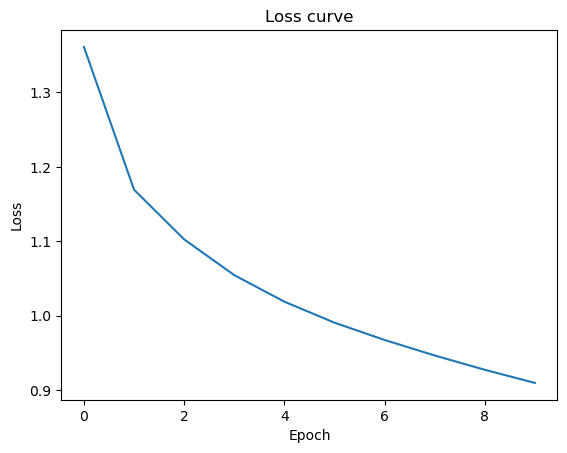

In [31]:
start_token = word2idx('<start>').numpy()

#initialise encoder, decoder, optimiser and loss object 
encoder = CNNEncoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)  # Decrease learning rate as training loss keeps increasing
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

#define train step function 
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    #initialise hidden state 
    hidden = decoder.reset_state(batch_size=target.shape[0])

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        dec_input = tf.expand_dims([start_token] * target.shape[0], 1)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features=features, hidden=hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = loss / int(target.shape[1])  # Avg loss across sequence length
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

#definne loss function 
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#set hyperparameters 

EPOCHS = 10
loss_history = []

# train the model with checkpoints so that we don't need to spend hours on it every time we make a small change
checkpoint_path = "checkpoints/train"
ckpt = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#start of training loop
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    steps_per_epoch = len(train_dataset)

    # use tqdm to create a progress bar
    pbar = tqdm(enumerate(train_dataset), total=steps_per_epoch)

    # iterate over training dataset
    for batch, (img_tensor, target) in pbar:
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

        pbar.set_description(f'Epoch {epoch+1} Loss: {total_loss / (batch + 1):.4f}')  # Update progress bar description
  
    # get average loss for the epoch
    epoch_loss = total_loss / steps_per_epoch
    loss_history.append(epoch_loss)
    
    print(f'Epoch {epoch+1} Loss {epoch_loss:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    #save checkpoint 
    ckpt_manager.save()

#plotting graphs
plt.plot(loss_history)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


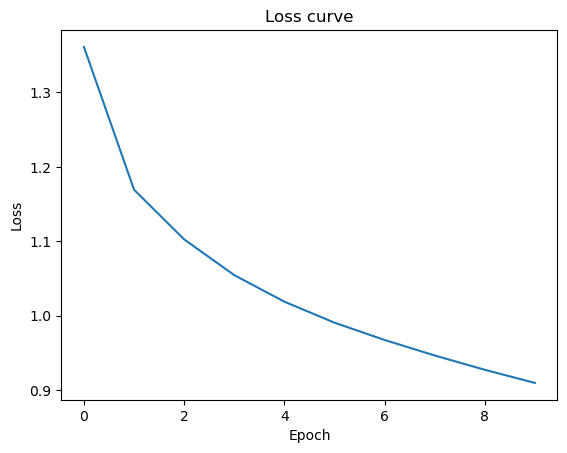

In [32]:
# Plot the loss curve 
plt.plot(loss_history)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Real captions:  ['[start] a brown dog is playing with a white and brown dog in a grassy and treed area [end]', '[start] a brown dog is rolling over in the grass while a white and brown dog stands next to it [end]', '[start] a brown dog lies on its back fighting with a brown and white dog [end]', '[start] the two dogs are playing in the yard [end]', '[start] two brown dogs are playing with each other on the grass with one dog laying on its side [end]']
Shape of features before reshaping: (1, 256)
Predicted Caption:  serve states bounding buckets races dinghy hood clothing mulch tulips ferns downward herself apparatus lab jackets squatting vine humans jesus siting coming stringed russell canon stains cloth noodle backpacks nuzzling lockers bananas dog without nose barefoot murky farmland wings bagpipes



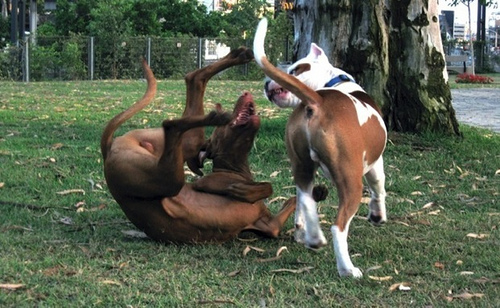

In [36]:

inception_v3 = InceptionV3(weights='imagenet', include_top=False)

#define evaluate function 
def evaluate(image_path): 
    #load img
    img = load_img(image_path, target_size=(299, 299))  # Resize the image to match InceptionV3's input shape
    img_array = img_to_array(img)  
    img_array = preprocess_input(img_array)  
    
    #expand dimensions
    temp_input = tf.expand_dims(img_array, 0)
    #get features with inceptionV3 model 
    img_tensor_val = inception_v3(temp_input)
    #initialise decoder class
    decoder = RNNDecoder(embedding_dim, units, vocab_size)
    hidden = decoder.reset_state(batch_size=1)
    
    # reshape feature tensorr
    img_tensor_val = tf.reshape(
        img_tensor_val,
        (img_tensor_val.shape[0], -1)  # Reshape to (batch_size, num_pixels * embedding_dim)
    )

    #get features with encoder 
    features = encoder(img_tensor_val)
    print("Shape of features before reshaping:", features.shape)  # Print the shape before reshaping
    
    #reshape 
    features = tf.reshape(features, (features.shape[0], -1, embedding_dim))  # Reshape to (batch_size, num_pixels, embedding_dim)

    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []
    
    # Generate captions word by word
    for i in range(max_length):
        # predict next word
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(idx2word(predicted_id).numpy())
        #append prediction to result
        if predicted_word == '[end]':
            return result
        result.append(predicted_word)
        
        # use the predicted word as input for the next prediction
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result


# get list of images
image_files = os.listdir(image_dir)
random_image_file = random.choice(image_files)
random_image_path = os.path.join(image_dir, random_image_file)
random_image_index = sorted_images.index(random_image_file)

feature_vector_tuple = tuple(image_to_feature_vector[random_image_file].flatten())

real_captions = fv_to_cap_vector[feature_vector_tuple]

print('Real captions: ', real_captions)

result = evaluate(random_image_path)

print('Predicted Caption: ', ' '.join(result))
print()

#display image 
Image.open(random_image_path)


In [34]:
def val_evaluate(val_dataset):
    total_loss = 0
    steps = 0

    for img_tensor, target in val_dataset:
        batch_loss = 0

        # forward pass through the encoder
        features = encoder(img_tensor)

        # initialise decoder hidden state
        hidden = decoder.reset_state(batch_size=target.shape[0])

        dec_input = tf.expand_dims([word2idx('[start]')] * target.shape[0], 1)

        #feeding the target as the next input
        for t in range(1, target.shape[1]):
            # pass features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # calc loss
            batch_loss = batch_loss + loss_function(target[:, t], predictions)

            dec_input = tf.expand_dims(target[:, t], 1)

        #get avg loss accross sequence 
        batch_loss /= int(target.shape[1])  
        total_loss = total_loss + batch_loss
        steps = steps + 1

    return total_loss / steps

# evaluate on the validation set
val_loss = val_evaluate(val_dataset)
print(f'Validation Loss: {val_loss:.4f}')


Validation Loss: 0.9876


2024-05-22 15:51:00.871928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
# Function to generate captions for validation set
def evaluate_image(image_tensor):
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(image_tensor, 0)
    features = encoder(temp_input)
    
    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(idx2word(predicted_id).numpy().decode('utf-8'))
        
        if idx2word(predicted_id).numpy().decode('utf-8') == '[end]':
            return result
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result


actual_captions = []
predicted_captions = []

for img_tensor, target in val_dataset.take(10):  # Limit to 10 batches for simplicity
    for i in range(len(img_tensor)):
        actual_caption = ' '.join([idx2word(idx).numpy().decode('utf-8') for idx in target[i] if idx > 0])
        actual_captions.append(actual_caption)
        
        predicted_caption = evaluate_image(img_tensor[i])
        predicted_captions.append(' '.join(predicted_caption))

# Calculate BLEU score for each pair of actual and predicted captions
bleu_scores = [sentence_bleu([actual.split()], pred.split()) for actual, pred in zip(actual_captions, predicted_captions)]
average_bleu_score = np.mean(bleu_scores)

print(f'Average BLEU Score: {average_bleu_score:.4f}')

Average BLEU Score: 0.0035


2024-05-22 15:52:08.704818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score

In [47]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_metrics(actual_caption, predicted_caption):
    # Smoothing function for BLEU score
    smoothing_function = SmoothingFunction().method4
    bleu_score = sentence_bleu([actual_caption.split()], predicted_caption.split(), smoothing_function=smoothing_function)

    # calc recall, precision, and F1 score
    actual_words = set(actual_caption.split())
    predicted_words = set(predicted_caption.split())

    recall = len(actual_words.intersection(predicted_words)) / len(actual_words)
    precision = len(actual_words.intersection(predicted_words)) / len(predicted_words)

    # Handle division by zero
    if recall == 0 or precision == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score, bleu_score

def evaluate_image(image_tensor):
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(image_tensor, 0)
    features = encoder(temp_input)
    
    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = idx2word(predicted_id).numpy().decode('utf-8')
        result.append(predicted_word)
        
        if predicted_word == '[end]':
            break
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    predicted_caption = ' '.join(result)
    precision, recall, f1_score, bleu_score = calculate_metrics(actual_captions[-1], predicted_caption)
    
    return predicted_caption, precision, recall, f1_score, bleu_score

# Generate captions for the validation set and calculate metrics
actual_captions = []
predicted_captions = []
precisions = []
recalls = []
f1_scores = []
bleu_scores = []

for img_tensor, target in val_dataset.take(10):  # Limit to 10 batches for simplicity
    for i in range(len(img_tensor)):
        actual_caption = ' '.join([idx2word(idx).numpy().decode('utf-8') for idx in target[i] if idx > 0])
        actual_captions.append(actual_caption)
        
        predicted_caption, precision, recall, f1_score, bleu_score = evaluate_image(img_tensor[i])
        predicted_captions.append(predicted_caption)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        bleu_scores.append(bleu_score)

# Calculate average metrics
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)
average_bleu_score = np.mean(bleu_scores)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average F1 Score: {average_f1_score:.4f}')
print(f'Average BLEU Score: {average_bleu_score:.4f}')


Average Precision: 0.2822
Average Recall: 0.2617
Average F1 Score: 0.2642
Average BLEU Score: 0.0305


2024-05-23 16:44:37.830448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
